# 이미지 컬러화(Image Colorization)
## Image Colorization Using Autoencoders and Resnet
- 참고원본
    - https://github.com/baldassarreFe/deep-koalarization
    - (논문) https://arxiv.org/abs/1712.03400 
    - https://github.com/baldassarreFe/deep-koalarization/blob/master/slides.pdf
    - https://www.kaggle.com/valkling/image-colorization-using-autoencoders-and-resnet
    - https://towardsdatascience.com/colorize-your-black-white-world-with-deep-learning-studio-cee66d35b9ff

# 실습 준비


## Google Driver와 Colab 연동

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## 실행위치 이동

In [0]:
# 현재 위치
!pwd

# 실행 위치 이동
%cd "/content/gdrive/My Drive/04_영상인식_copied/CH12"

# 이동된 위치 확인
!pwd
!ls -al


/content
/content/gdrive/My Drive/04_영상인식_copied/CH12
/content/gdrive/My Drive/04_영상인식_copied/CH12
total 112776
-rw------- 1 root root 56476048 Feb 18 03:34 Art_Colorization_Model.h5
-rw------- 1 root root  2263581 Feb 18 05:46 Colorization_190218.ipynb
-rw------- 1 root root   259358 Feb 15 04:32 colorization_model.png
-rw------- 1 root root     1786 Feb 18 05:49 Colorization_V2_190218.ipynb
drwx------ 2 root root     4096 Feb 14 07:36 data
-rw------- 1 root root 56475664 Feb 15 09:22 my_model.h5


# 데이터 학습을 위한 준비


## 필요한 라이브러리 불러오기

In [0]:
import os

import random
import warnings
import sys
from tqdm import tqdm


import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt


from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed



Using TensorFlow backend.


## 학습 데이터 확인
- 데이터 원본주소 : https://github.com/Rajat2712/Deep-Learning-Studio/tree/master/Colorizing%20B%26W%20images/images
- test 파일중 color 이미지가 있어 삭제후 이미지 업로드 함 

In [0]:
# dataset tar파일이 있는 폴더로 이동
%cd /content/gdrive/My Drive/04_영상인식_copied/CH12/data

# 파일 확인
%pwd
%ls -al

/content/gdrive/My Drive/04_영상인식_copied/CH12/data
total 476056
-rw------- 1 root root  17743360 Feb 15 00:54 Test.tar
-rw------- 1 root root 469737984 Feb 14 07:43 Train.tar


## 압축해제
- 압축해제시 구글 드라이브와의 싱크가 불안정하여 발생되는 이미지 소실을 방지하기 위하여 tmp 파일 밑으로 압축해제
- 모든 런타임 재설정시 dataset은 사라짐
- dataset 압축해제 오랜시간 걸리지 않으므로 이경로로 푸는걸 추천함

In [0]:
# /tmp/밑으로 데이터 압축해제
!tar xf Test.tar -C /tmp/
!tar xf Train.tar -C /tmp/

# 파일 확인
!echo /tmp
!ls -al /tmp

/tmp
total 296
drwxrwxrwt 1 root root   4096 Feb 18 05:55 .
drwxr-xr-x 1 root root   4096 Feb 18 05:47 ..
srw------- 1 root root      0 Feb 18 05:49 drivefs_ipc.0
srw------- 1 root root      0 Feb 18 05:49 drivefs_ipc.0_shell
drwxr-xr-x 2 root root  20480 Feb 15 00:52 Test
drwxr-xr-x 2 root root 274432 Jan 25 02:21 Train


## 데이터 read

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 1)

# train 데이터 경로
TRAIN_PATH = '/tmp/Train/'
train_ids = next(os.walk(TRAIN_PATH))[2]

# test 데이터 경로
TEST_PATH = '/tmp/Test/'
test_ids = next(os.walk(TEST_PATH))[2]

print('학습데이터 : {} 개 ' .format( len(train_ids) ) )
print('테스트데이터 : {} 개 ' .format( len(test_ids) ) )

학습데이터 : 9294 개 
테스트데이터 : 478 개 


### 학습 데이터
- data 9000여개 전부 올릴 시 메모리 부족으로 인하여 후반부에 런타임이 초기화 되는 문제 발생
- train data 2000개로 실습

In [0]:
%%time
# X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
X_train = np.zeros((2000, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
missing_count = 0
print('Getting train images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=2000):
#for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_+''
    try:
        img = imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n-missing_count] = img
    except:
#         print(" Problem with: "+path)
        missing_count += 1

X_train = X_train.astype('float32') / 255.
print("Total missing: "+ str(missing_count))

Getting train images ... 


9294it [02:13, 69.74it/s]


Total missing: 7294
CPU times: user 2min 27s, sys: 1min 42s, total: 4min 10s
Wall time: 2min 14s


(2000, 256, 256, 3)


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


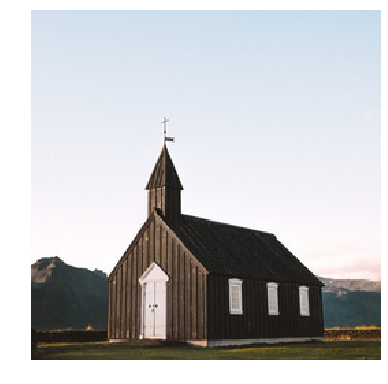

In [0]:
# train data 확인
print(X_train.shape)

imshow(X_train[111])
plt.axis('off')
plt.show()

### 테스트 데이터

In [0]:
%%time
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
missing_count = 0
print('Getting test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_+''
    try:
        img = imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n-missing_count] = img
    except:
#         print(" Problem with: "+path)
        missing_count += 1

X_test = X_test.astype('float32') / 255.
print("Total missing: "+ str(missing_count))

Getting test images ... 


100%|██████████| 478/478 [00:09<00:00, 50.96it/s]


Total missing: 0
CPU times: user 8.51 s, sys: 9.34 s, total: 17.8 s
Wall time: 9.73 s


(478, 256, 256, 3)


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


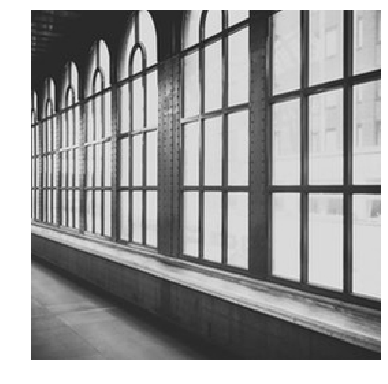

In [0]:
# train data 확인
print(X_test.shape)

imshow(X_test[111])
plt.axis('off')
plt.show()

# 학습 모델 구성
- 모델은 encoder-decoder로 구성된 conv layer와 미리 학습된 resnet classifier를 조합하여 구성


## Inception 모델 구성

In [0]:
# keras에 저장되어 있는 모듈로 resnetv2모델 불러오기 
# weight는 imagenet 학습한 weight 
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.get_default_graph()

Instructions for updating:
Colocations handled automatically by placer.


## 전체 모델 구성
- encoder의 출력과 병렬로 오늘날의 가장 강력한 분류기중 하나인 Inception ResNet V2를 입력으로 하여 퓨전 레이어 구성
- 퓨전 레이어를 입력으로 받은 decoder에서 색체 구성을 진행하게 된다
- 세부 필터개수등은 일부 수정된 것들이 있다.

In [0]:
def Colorize():
    # resnet을 통과하고 나온 출력값
    embed_input = Input(shape=(1000,))
    
    #Encoder
    encoder_input = Input(shape=(256, 256, 1,))
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_input)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    
    #Fusion
    # encoder output 과 resnet 통과 output concatenate
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

model = Colorize()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 256, 256, 128 1280        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 128 0           conv2d_204[0][0]                 
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 128, 128, 128 262272      max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
conv2d_206

## 모델구조 보이기 

/content/gdrive/My Drive/04_영상인식_copied/CH12


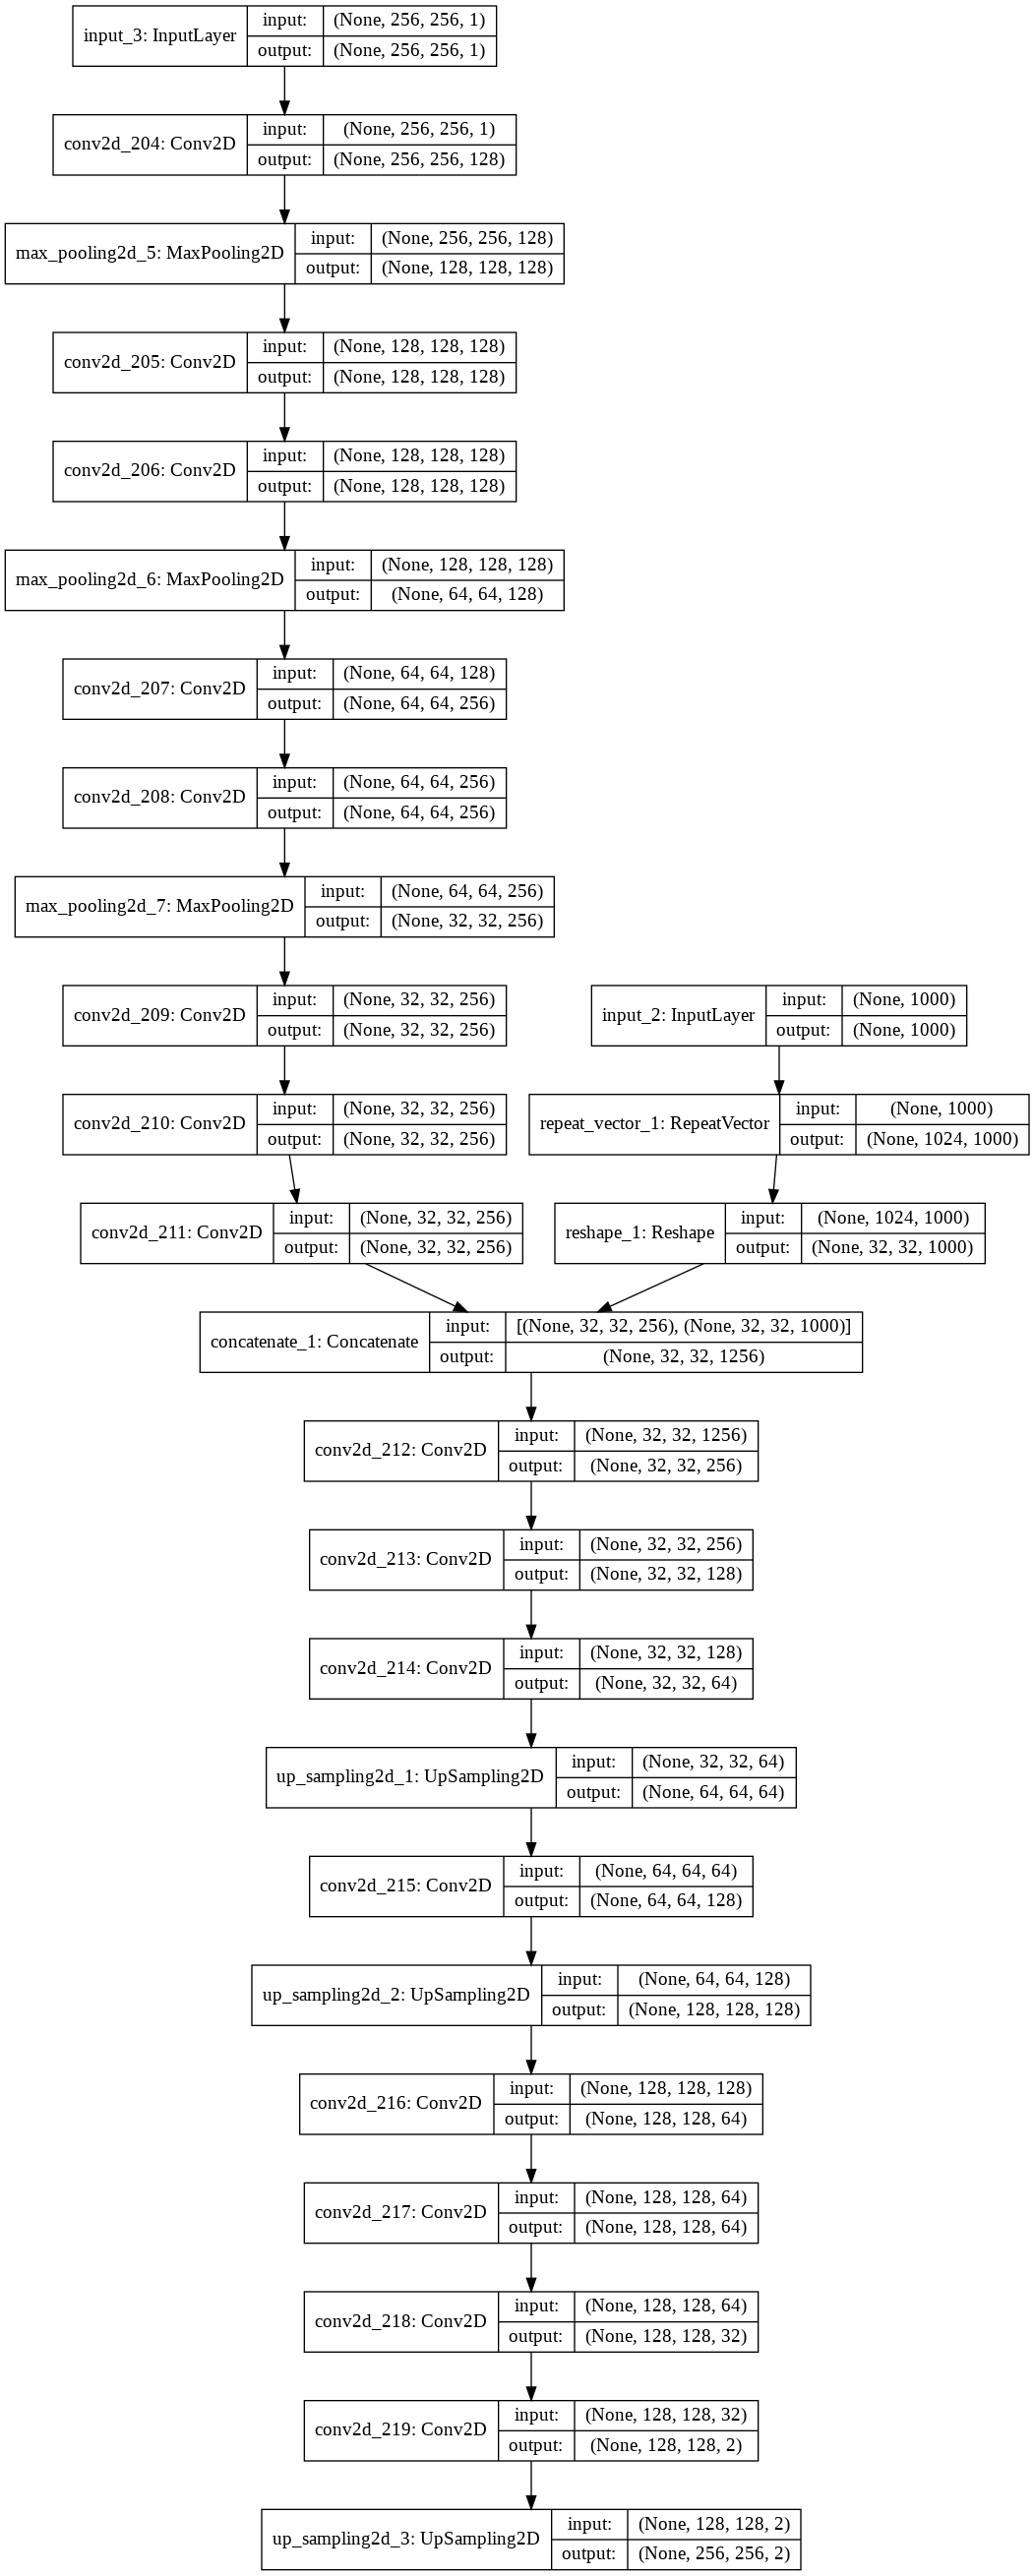

In [0]:
# 모델 구조 이미지로 저장할 위치로 이동
%cd /content/gdrive/My Drive/04_영상인식_copied/CH12

from keras.utils.vis_utils import plot_model
from IPython.display import Image, display

# 구조를 이미지로 저장
plot_model(model, show_shapes=True, to_file='colorization_model.png')

# 이미지 보이기
display(Image(filename='colorization_model.png')) 


## Data Generator 함수들

In [0]:
# 퓨전레이어에 input으로 들어갈 data 만드는 함수
# resnet 통과

def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image 변형 ( 이미지 변형을 위한 모듈 - ImageDataGenerator )
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# 학습 데이터 Generate 함수
batch_size = 10
def image_a_b_gen(dataset=X_train, batch_size = batch_size):
    for batch in datagen.flow(dataset, batch_size=batch_size):
        X_batch = rgb2gray(batch)
        # resnet에 들어갈 input
        grayscaled_rgb = gray2rgb(X_batch)
        
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        # incoder에 들어갈 input
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        
        # 학습목표
        Y_batch = lab_batch[:,:,:,1:] / 128
        
        # 루프의 반환 값
        yield [X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch

### image_a_b_gen 함수 살펴보기


#### resnet layer에 들어갈 data generate
- 학습을 위한 4차원 데이터(데이터갯수, 가로, 세로, 채널)중 7번째 값 즉 하나의 데이터 셋만 가지고 실험

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


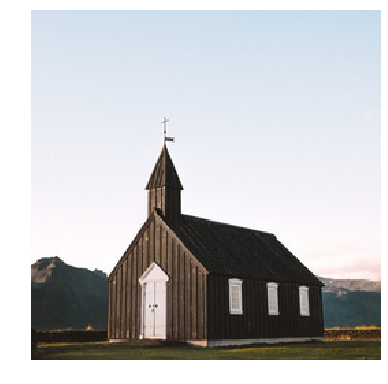

In [0]:
imshow(X_train[111])
plt.axis('off')
plt.show()

In [0]:
# datagen.flow는 기본적으로 무한루프를 돌기 때문에 break를 걸어준다
a= X_train[111].reshape(-1,256,256,3)
batches = 0
for i in datagen.flow(a, batch_size=1):
    #print(i)
    batches += 1
    if batches >= 1:
            break

# ImageDataGenerator의 parameter 들에 의해 data가 변경되었다.

3차원 original data의 shape :  (256, 256, 3)

 1차원 grayscale data의 shape :  (256, 256)


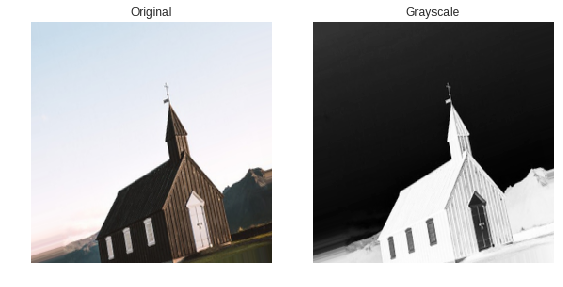

In [0]:
# 샘플데이터 a와 rgb2gray 변경을한 데이터 비교

# matplotlib 라이브러리로 보여주기 위하여 shape 변경
original = i.reshape(256,256,3)
print('3차원 original data의 shape : ', original.shape) 

grayscale = rgb2gray(original)
print('\n 1차원 grayscale data의 shape : ', grayscale.shape)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(original)
ax[0].axis('off')
ax[0].set_title("Original")
ax[1].imshow(grayscale)
ax[1].axis('off')
ax[1].set_title("Grayscale")

fig.tight_layout()

plt.show()

차원 grayscale data의 shape :  (256, 256)

 3차원 rgbscale data의 shape :  (256, 256, 3)


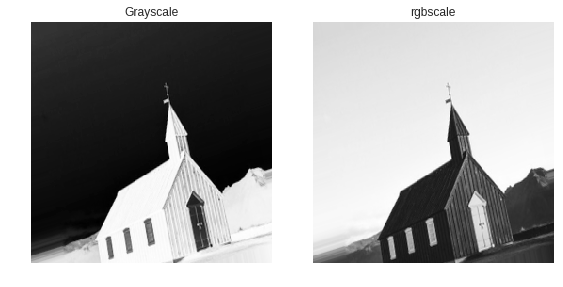

In [0]:
# 1차원 gray scale로 변경한 데이터를 resnet에 input으로 넣기위하여 rgb scale로 변경

print('차원 grayscale data의 shape : ', grayscale.shape) 
rgbscale = gray2rgb(grayscale)
print('\n 3차원 rgbscale data의 shape : ', rgbscale.shape)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(grayscale)
ax[0].axis('off')
ax[0].set_title("Grayscale")
ax[1].imshow(rgbscale)
ax[1].axis('off')
ax[1].set_title("rgbscale")

fig.tight_layout()
plt.show()

#### incoder input에 들어갈 data generate
- originale image를 표준광원 lab image data로 변환
- 표준광원 : https://www.scienceall.com/%ED%91%9C%EC%A4%80%EA%B4%91%EC%9B%90/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3차원 original data의 shape :  (256, 256, 3)

 3차원 lab scale 의 shape :  (256, 256, 3)

 lab scale의 0번째 채널 shape :  (256, 256)


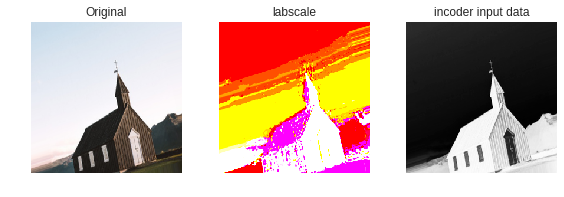

In [0]:
# originale image --> lab image
print('3차원 original data의 shape : ', original.shape) 

# lab scale로 변형
lab_batch = rgb2lab(original)
print('\n 3차원 lab scale 의 shape : ', lab_batch.shape)

# lab scale 데이터 채널중 0번째 채널 만 추출
# incoder에 input으로 들어가는 data이다
X_batch = lab_batch[:,:,0]
print('\n lab scale의 0번째 채널 shape : ', X_batch.shape)


fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(original)
ax[0].axis('off')
ax[0].set_title("Original")
ax[1].imshow(lab_batch)
ax[1].axis('off')
ax[1].set_title("labscale")
ax[2].imshow(X_batch)
ax[2].axis('off')
ax[2].set_title("incoder input data")

fig.tight_layout()
plt.show()

In [0]:
# 학습 목표가 될 Y_batch data
Y_batch = lab_batch[:,:,1:]

## 학습모델 요약
- encoder input : 학습할 컬러 원본 이미지 data 표준광원으로 scale --> 0번째 채널 data input으로 추출
- inception-resnet-v2 input : 원본 이미지 data 를 gray scale로 한번 변형 후 다시 rgb scale로 변형하여 추출
- fushin layer input : encoder output과 inception output 를 concatenate 
- decoder output : 마지막에 필터 2개를 사용하여 깊이가 2인 데이터를 추출하여 upsamepling
- 학습 loss : 학습하여 나온 채널2개의 decoder output 과, 표준광원으로 scale 후 추출한 채널1,2번 데이터를 비교하면서 학습

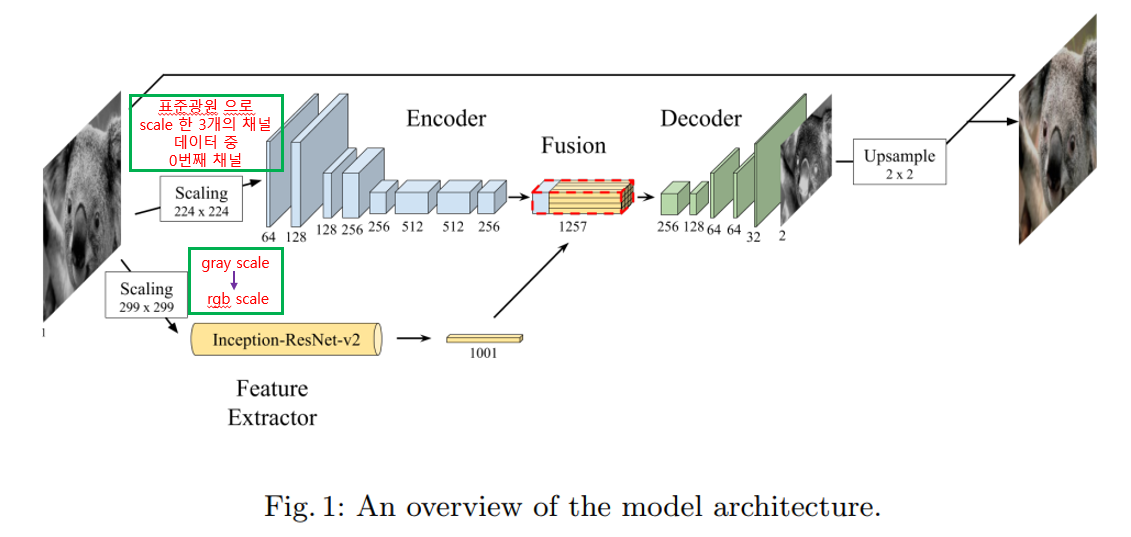

# 학습

## Checkpoints 설정

In [0]:
# learning rate 감소시키며 학습
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)

# 모델의 정확도가 최고일때마다 저장
filepath = "/content/gdrive/My Drive/04_영상인식_copied/CH12/Art_Colorization_Model.h5"
checkpoint = ModelCheckpoint(filepath,
                             save_best_only=True,
                             monitor='loss',
                             mode='min')

model_callbacks = [learning_rate_reduction,checkpoint]

## 학습시작
- colab 성능의 한계로인해 적정한 값 설정해야함
- batch_size : 10
- epcohs : 10
- 학습을 원하시면 아래의 셀을 실행(colab에서 약 1시간정도 소요) 
- 미리 학습된 모델은 Art_Colorization_Model_10.h5로 저장되어 있음

In [0]:
%%time
BATCH_SIZE = 10
model.fit_generator(image_a_b_gen(X_train,BATCH_SIZE),
            epochs=10,
            verbose=1,
            steps_per_epoch=X_train.shape[0]/BATCH_SIZE,
            callbacks=model_callbacks                               
                   )

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
200/200 [==============================] - 264s 1s/step - loss: 0.0128
Epoch 2/10
200/200 [==============================] - 237s 1s/step - loss: 0.0100
Epoch 3/10
200/200 [==============================] - 245s 1s/step - loss: 0.0100
Epoch 4/10
200/200 [==============================] - 245s 1s/step - loss: 0.0100
Epoch 5/10
200/200 [==============================] - 245s 1s/step - loss: 0.0101

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
200/200 [==============================] - 245s 1s/step - loss: 0.0101
Epoch 7/10
200/200 [==============================] - 246s 1s/step - loss: 0.0100
Epoch 8/10
200/200 [==============================] - 246s 1s/step - loss: 0.0100

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 9/10
200/200 [==============================] - 245s 1s/step - loss: 0.0100
Epoch 10/10
200/200 [==============================]

# 학습한 결과로 Colorizing 

In [0]:
sample = X_test
color_me = gray2rgb(rgb2gray(sample))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

output = model.predict([color_me, color_me_embed])
output = output * 128

decoded_imgs = np.zeros((len(output),256, 256, 3))

for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    decoded_imgs[i] = lab2rgb(cur)

# 결과 파일로 저장 하고 싶으면 result폴더 생성후 밑의 코드 실행(for문 안에)
#cv2.imwrite("result/img_"+str(i)+".jpg", lab2rgb(cur))

## colorizing 한 이미지 보이기

원하시는 이미지를 넣어주세요(0~475)50
3개의 흑백 이미지를 컬러화 하겠습니다


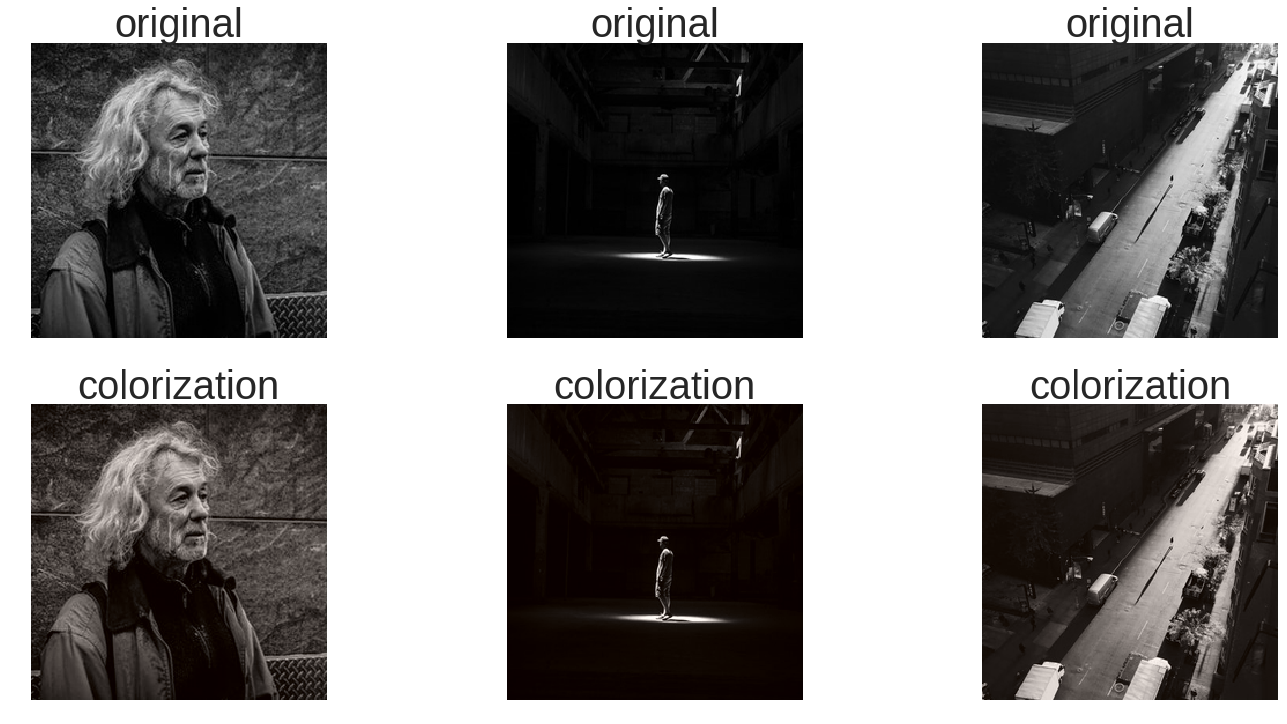

In [0]:
img_num = input('원하시는 이미지 번호를 입력해 주세요(0~475) : ')
print('3개의 흑백 이미지를 컬러화 하겠습니다')

plt.figure(figsize=(20, 15))
for i in range(3):
    # grayscale
    plt.subplot(3, 3, i + 1)
    plt.imshow((X_test)[i+int(img_num)])
    plt.axis('off')
    plt.title('original', fontsize=40)
 
    # recolorization
    plt.subplot(3, 3, i + 1 + 3)
    plt.imshow(decoded_imgs[i+int(img_num)])
    plt.axis('off')
    plt.title('colorization', fontsize=40)
    
    
 
plt.tight_layout()
plt.show()

# 재학습한 결과로 Colorizing
- 학습을 설계한 논문과 설명을 참고하자면 학습 데이터는 60000개
- 90% traing , 10% validation/test 로 split 하여 학습
- batch size는 100
- 약 23시간 학습
- NVIDIA Tesla k80 GPU를 사용하여 학습하였다.
- 60000개의 데이터와 batch size의 크기로 보아 colab에 비해 훨씬좋은 컴퓨팅파워를 가지고 학습 하였다.
- 필자는 비슷한 결과를 얻기위해 추가로 딥러닝용 서버에서 imagenet 2012 validation data (40000여장)로 학습을 진행 하였다
- http://hpkim0512.blogspot.com/2017/12/sdf.html
- batch size는 50으로 하여 75epoch으로 학습을 진행하였다.
- 총 학습시간은 60시간 정도였다

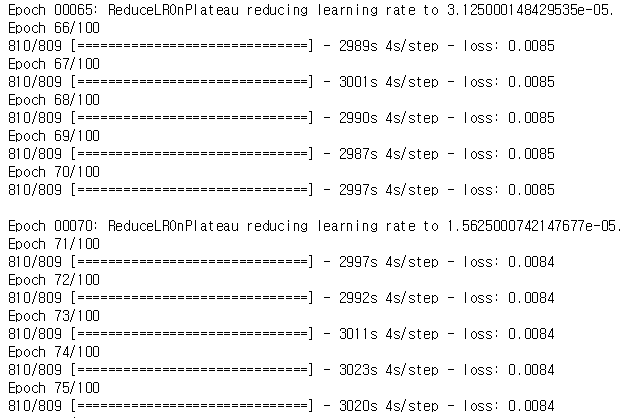

## 학습한 모델 불러오기

In [0]:
# 저장된 모델 확인(Art_Colorization_Model_75epoch.h5)
%ls -al

total 169905
-rw------- 1 root root 56475968 Feb 18 10:19 Art_Colorization_Model_75epoch.h5
-rw------- 1 root root 56476048 Feb 18 09:51 Art_Colorization_Model.h5
-rw------- 1 root root  2264100 Feb 18 09:10 Colorization_190218.ipynb
-rw------- 1 root root   259358 Feb 18 09:07 colorization_model.png
-rw------- 1 root root  2025861 Feb 18 10:19 Colorization_V2_190218.ipynb
drwx------ 2 root root     4096 Feb 14 07:36 data/
-rw------- 1 root root 56475664 Feb 15 09:22 my_model.h5


In [0]:
model_2 = load_model('Art_Colorization_Model_75epoch.h5')

## Colorizing

In [0]:
sample = X_test
color_me = gray2rgb(rgb2gray(sample))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

output = model_2.predict([color_me, color_me_embed])
output = output * 128

decoded_imgs = np.zeros((len(output),256, 256, 3))

for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    decoded_imgs[i] = lab2rgb(cur)

# 결과 파일로 저장 하고 싶으면 result폴더 생성후 밑의 코드 실행(for문 안에)
#cv2.imwrite("result/img_"+str(i)+".jpg", lab2rgb(cur))

In [1]:
img_num = input('원하시는 이미지 번호를 입력해 주세요(0~475) : ')
print('3개의 흑백 이미지를 컬러화 하겠습니다')

plt.figure(figsize=(20, 15))
for i in range(3):
    # grayscale
    plt.subplot(3, 3, i + 1)
    plt.imshow((X_test)[i+int(img_num)])
    plt.axis('off')
    plt.title('original', fontsize=40)
 
    # recolorization
    plt.subplot(3, 3, i + 1 + 3)
    plt.imshow(decoded_imgs[i+int(img_num)])
    plt.axis('off')
    plt.title('colorization', fontsize=40)
    
    
 
plt.tight_layout()
plt.show()

KeyboardInterrupt: ignored